Takes the skimmed parquet files (output of bbVVSkimmer) and evaluates the HWW Tagger.

Author(s): Raghav Kansal

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep

plt.rcParams.update({"font.size": 16})
plt.style.use(hep.style.CMS)
hep.style.use("CMS")

import os
from os import listdir
from os.path import exists
import pickle

from tqdm import tqdm

import utils
from hh_vars import samples, nonres_samples, res_samples, nonres_sig_keys, res_sig_keys

MAIN_DIR = "../../../"

samples = samples | nonres_samples

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# plot_dir = f"{MAIN_DIR}/plots/TaggerAnalysis/23Apr28"
plot_dir = f"{MAIN_DIR}/plots/BDT/23May12"
os.system(f"mkdir -p {plot_dir}")

samples_dir = f"{MAIN_DIR}/../data/skimmer/Feb24"
signal_samples_dir = f"{MAIN_DIR}/../data/skimmer/Mar10_2"
year = "2017"

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [ ]:
from collections import OrderedDict


res_samples = OrderedDict()

res_mps = [
    # (1000, 125),
    # (1400, 125),
    (1400, 150),
    # (1800, 125),
    (1800, 150),
    (1800, 190),
    # (2200, 125),
    (2200, 150),
    (2200, 190),
    (2200, 250),
    # (3000, 125),
    # (3000, 150),
    # (3000, 190),
    # (3000, 250),
    # (3000, 350),
]

for mX, mY in res_mps:
    res_samples[
        f"X[{mX}]->H(bb)Y[{mY}](VV)"
    ] = f"NMSSM_XToYH_MX{mX}_MY{mY}_HTo2bYTo2W_hadronicDecay"

res_sig_keys = list(res_samples.keys())

In [ ]:
# Both Jet's Regressed Mass above 50, electron veto
filters = [
    [
        ("('ak8FatJetParticleNetMass', '0')", ">=", 50),
        ("('ak8FatJetParticleNetMass', '1')", ">=", 50),
        # ("('nGoodElectrons', '0')", "==", 0),
    ],
]

events_dict = utils.load_samples(
    samples_dir, {sig_key: samples[sig_key] for sig_key in nonres_sig_keys}, year, filters=filters
)
events_dict |= utils.load_samples(signal_samples_dir, res_samples, year, filters=filters)
# events_dict["HHbbVV"] = pd.read_parquet("../../../0-1.parquet")
# events_dict["HHbbVV"] = utils.load_samples(samples_dir, {sig_key: samples[sig_key]}, year)["HHbbVV"]

In [ ]:
# (column name, number of subcolumns)
save_columns = [
    ("weight", 1),
    ("ak8FatJetPt", 2),
    ("ak8FatJetMsd", 2),
    ("ak8FatJetParTMD_THWW4q", 2),
    ("ak8FatJetParTMD_probHWW4q", 2),
    ("ak8FatJetParTMD_probHWW3q", 2),
    ("ak8FatJetParTMD_probQCD", 2),
    ("ak8FatJetParTMD_probT", 2),
    ("ak8FatJetParticleNet_Th4q", 2),
]

### Signal Processing

In [ ]:
for sig_key, events in list(events_dict.items()):
    sig_dict = {}
    masks = events["ak8FatJetHVV"].astype(bool)

    for column, num_idx in save_columns:
        if num_idx == 1:
            sig_dict[column] = np.tile(events[column].values, 2)[masks]
        else:
            sig_dict[column] = np.nan_to_num(events[column].values[masks], copy=True, nan=0)

    events_dict[sig_key] = sig_dict

### Background Processing

In [ ]:
full_samples_list = listdir(f"{samples_dir}/{year}")

# reformat into ("column name", "idx") format for reading multiindex columns
bg_column_labels = []
for key, num_columns in save_columns:
    for i in range(num_columns):
        bg_column_labels.append(f"('{key}', '{i}')")


bg_keys = ["TT", "QCD"]
# bg_keys = ["QCD"]

for bg_key in bg_keys:
    events_dict[bg_key] = {}
    for sample in full_samples_list:
        if bg_key not in sample:
            continue

        # doesn't have probT for some reason
        if sample in ["QCD_HT300to500", "QCD_HT200to300"]:
            continue

        if "HH" in sample or "GluGluH" in sample:
            continue

        if not exists(f"{samples_dir}/{year}/{sample}/parquet"):
            print(f"No parquet file for {sample}")
            continue

        print(sample)

        with utils.timer():
            events = pd.read_parquet(
                f"{samples_dir}/{year}/{sample}/parquet",
                columns=bg_column_labels,
            )

        pickles_path = f"{samples_dir}/{year}/{sample}/pickles"
        n_events = utils.get_nevents(pickles_path, year, sample)
        events["weight"] /= n_events

        for var, num_idx in save_columns:
            if num_idx == 1:
                values = np.tile(events[var].values, 2).reshape(-1)
            else:
                values = np.reshape(events[var].values, -1)

            if var in events_dict[bg_key]:
                events_dict[bg_key][var] = np.concatenate(
                    (events_dict[bg_key][var], values), axis=0
                )
            else:
                events_dict[bg_key][var] = values

In [ ]:
# print weighted sample yields
for sample in events_dict:
    tot_weight = np.sum(events_dict[sample]["weight"])
    print(f"Pre-selection {sample} yield: {tot_weight:.2f}")

In [ ]:
for sample, events in events_dict.items():
    if "ak8FatJetParTMD_THWWvsT" not in events:
        events["ak8FatJetParTMD_THWWvsT"] = (
            events["ak8FatJetParTMD_probHWW3q"] + events["ak8FatJetParTMD_probHWW4q"]
        ) / (
            events["ak8FatJetParTMD_probHWW3q"]
            + events["ak8FatJetParTMD_probHWW4q"]
            + events["ak8FatJetParTMD_probQCD"]
            + events["ak8FatJetParTMD_probT"]
        )

### Cuts

In [ ]:
"""
``cuts_dict`` will be of format:
{
    sample1: {
        "cut1var1_min_max_cut1var2...": cut1,
        "cut2var2...": cut2,
        ...
    },
    sample2...
}
"""
pt_key = "Pt"
msd_key = "Msd"
var_prefix = "ak8FatJet"

cutvars_dict = {"Pt": "pt", "Msd": "msoftdrop"}

all_cuts = [
    {pt_key: [300, 3000]},
    # {pt_key: [400, 600], msd_key: [60, 150]},
    # {pt_key: [300, 1500], msd_key: [110, 140]},
]

var_labels = {pt_key: "pT", msd_key: "mSD"}

cuts_dict = {}
cut_labels = {}  # labels for plot titles, formatted as "var1label: [min, max] var2label..."

for sample, events in events_dict.items():
    # print(sample)
    cuts_dict[sample] = {}
    for cutvars in all_cuts:
        cutstrs = []
        cutlabel = []
        cuts = []
        for cutvar, (cutmin, cutmax) in cutvars.items():
            cutstrs.append(f"{cutvars_dict[cutvar]}_{cutmin}_{cutmax}")
            cutlabel.append(f"{var_labels[cutvar]}: [{cutmin}, {cutmax}]")
            cuts.append(events[f"{var_prefix}{cutvar}"] >= cutmin)
            cuts.append(events[f"{var_prefix}{cutvar}"] < cutmax)

        cutstr = "_".join(cutstrs)
        cut = np.prod(cuts, axis=0)
        cuts_dict[sample][cutstr] = cut.astype(bool)

        if cutstr not in cut_labels:
            cut_labels[cutstr] = " ".join(cutlabel)

### Histograms

In [ ]:
plot_vars = {
    "th4q": {
        "title": "ParticleNet Non-MD Th4q",
        "score_label": "ak8FatJetParticleNet_Th4q",
        "colour": "orange",
    },
    "thvv4q": {
        "title": "ParT MD THWW",
        "score_label": "ak8FatJetParTMD_THWW4q",
        "colour": "green",
    },
    "thvv4qt": {
        "title": "ParT MD THWW",
        "score_label": "ak8FatJetParTMD_THWWvsT",
        "colour": "green",
    },
}

In [ ]:
samples = {"tt": "TT", "qcd": "QCD", "HHbbVV": "HHbbVV"}

plt.rcParams.update({"font.size": 16})
plt.style.use(hep.style.CMS)
hep.style.use("CMS")

for t, pvars in plot_vars.items():
    for cutstr in cut_labels:
        plt.figure(figsize=(16, 12))
        # plt.suptitle(f"HVV FatJet {pvars['title']} Scores", y=0.95)
        # plt.title(cut_labels[cutstr], fontsize=20)

        for sample, colour, skip in [("HHbbVV", "red", 1), ("QCD", "deepskyblue", 4)]:
            _ = plt.hist(
                events_dict[sample][pvars["score_label"]][cuts_dict[sample][cutstr]][::skip],
                histtype="step",
                bins=np.linspace(0, 1, 101),
                label=f"{sample}",
                linewidth=2,
                color=colour,
                density=True,
                weights=events_dict[sample]["weight"][cuts_dict[sample][cutstr]][::skip],
            )

        plt.ylabel("# Jets (A.U.)")
        plt.xlabel(f"{pvars['title']} Score")
        plt.legend()
        plt.savefig(
            f"{plot_dir}/{t}_hist_{cutstr}.pdf",
            bbox_inches="tight",
        )

### ROCs

In [ ]:
from sklearn.metrics import roc_curve, auc

rocs = {}
# sig_key = "HHbbVV"
bg_keys = ["TT", "QCD"]
bg_skip = 4


for cutstr in cut_labels:
    # print(cutstr)
    rocs[cutstr] = {}
    for sig_key in tqdm(nonres_sig_keys + res_sig_keys):
        rocs[cutstr][sig_key] = {}
        sig_cut = cuts_dict[sig_key][cutstr]
        bg_cuts = [cuts_dict[bg_key][cutstr] for bg_key in bg_keys]

        y_true = np.concatenate(
            [
                np.ones(np.sum(sig_cut)),
                np.zeros(int(np.ceil(np.sum(np.concatenate(bg_cuts)) / bg_skip))),
            ]
        )

        weights = np.concatenate(
            [events_dict[sig_key]["weight"][sig_cut]]
            + [
                events_dict[bg_key]["weight"][bg_cut][::bg_skip]
                for bg_key, bg_cut in zip(bg_keys, bg_cuts)
            ],
        )

        for t, pvars in plot_vars.items():
            score_label = pvars["score_label"]
            scores = np.concatenate(
                [events_dict[sig_key][score_label][sig_cut]]
                + [
                    events_dict[bg_key][score_label][bg_cut][::bg_skip]
                    for bg_key, bg_cut in zip(bg_keys, bg_cuts)
                ],
            )
            fpr, tpr, thresholds = roc_curve(y_true, scores, sample_weight=weights)
            rocs[cutstr][sig_key][t] = {
                "fpr": fpr,
                "tpr": tpr,
                "thresholds": thresholds,
                # "auc": auc(fpr, tpr),
            }

All signals in same plot

In [ ]:
sig_split_points = [
    # [
    #     (1000, 125),
    #     (1400, 125),
    #     (1800, 125),
    #     (2200, 125),
    #     (3000, 125),
    # ],
    [
        (1400, 150),
        (1800, 150),
        (1800, 190),
        (2200, 150),
        (2200, 190),
        (2200, 250),
    ],
    # [
    #     (3000, 125),
    #     (3000, 150),
    #     (3000, 190),
    #     (3000, 250),
    #     (3000, 350),
    # ],
]

sig_splits = [
    ["HHbbVV"] + [f"X[{mX}]->H(bb)Y[{mY}](VV)" for (mX, mY) in mps] for mps in sig_split_points
]

In [ ]:
xlim = [0, 0.8]
ylim = [1e-6, 1]

plot_thresholds = [0.98, 0.96, 0.94, 0.9, 0.8, 0.6, 0.4]
th_colours = ["#9381FF", "#1f78b4", "#a6cee3", "#ff7f00", "#7CB518", "#EDB458", "#36213E"]

plt.rcParams.update({"font.size": 24})

sig_colours = [
    "#23CE6B",
    "#ffbaba",
    "#ff7b7b",
    "#ff5252",
    # "#EDB458",
    "#a70000",
    "#885053",
    "#3C0919",
]

plot_vars = {
    # "th4q": {
    #     "title": "ParticleNet Non-MD Th4q",
    #     "score_label": "ak8FatJetParticleNet_Th4q",
    #     "colour": "orange",
    # },
    # "thvv4q": {
    #     "title": "ParT MD THWW",
    #     "score_label": "ak8FatJetParTMD_THWW4q",
    #     "colour": "green",
    # },
    "thvv4qt": {
        "title": "ParT MD THWW",
        "score_label": "ak8FatJetParTMD_THWWvsT",
        "colour": "green",
    },
}


for cutstr in cut_labels:
    for t, pvars in plot_vars.items():
        for j, plot_sig_keys in enumerate(sig_splits):
            split_str = "allsigs" if len(sig_splits) == 1 else f"sigs{j}"
            pths = {th: [[], []] for th in plot_thresholds}
            plt.figure(figsize=(12, 12))
            for i, sig_key in enumerate(plot_sig_keys):
                roc = rocs[cutstr][sig_key][t]
                c = sig_colours[i]
                plt.plot(
                    roc["tpr"],
                    roc["fpr"],
                    # label=f"{sig_key} AUC: {roc['auc']:.2f}",
                    label=f"{sig_key}",
                    linewidth=2,
                    color=c,
                )
                for th in plot_thresholds:
                    idx = find_nearest(thresholds, th)
                    pths[th][0].append(roc["tpr"][idx])
                    pths[th][1].append(roc["fpr"][idx])

                # plt.vlines(
                #     x=roc["tpr"][np.searchsorted(roc["fpr"], 0.01)],
                #     ymin=0,
                #     ymax=0.01,
                #     colors=c,
                #     linestyles="dashed",
                # )

            for k, th in enumerate(plot_thresholds):
                plt.scatter(
                    *pths[th],
                    marker="o",
                    s=40,
                    label=f"THWW > {th:.2f}",
                    color=th_colours[k],
                    zorder=100,
                )
            hep.cms.label(data=False, rlabel="")
            # plt.hlines(y=0.01, xmin=0, xmax=1, colors="lightgrey", linestyles="dashed")
            plt.yscale("log")
            plt.xlabel("Signal efficiency")
            plt.ylabel("Background efficiency")
            # plt.suptitle(f"HVV FatJet {pvars['title']} ROC", y=0.95)
            # plt.title(cut_labels[cutstr], fontsize=20)
            plt.xlim(*xlim)
            plt.ylim(*ylim)
            plt.legend(loc="lower right")
            plt.savefig(f"{plot_dir}/roccurve_{split_str}_{t}_{cutstr}.pdf", bbox_inches="tight")

Old vs New Tagger in same plot

In [ ]:
xlim = [0, 0.6]
ylim = [1e-6, 1]

for cutstr in cut_labels:
    plt.figure(figsize=(12, 12))
    for t, pvars in plot_vars.items():
        plt.plot(
            rocs[cutstr][t]["tpr"][::10],
            rocs[cutstr][t]["fpr"][::10],
            label=f"{pvars['title']} AUC: {rocs[cutstr][t]['auc']:.2f}",
            linewidth=2,
            color=pvars["colour"],
        )
        plt.vlines(
            x=rocs[cutstr][t]["tpr"][np.searchsorted(rocs[cutstr][t]["fpr"], 0.01)],
            ymin=0,
            ymax=0.01,
            colors=pvars["colour"],
            linestyles="dashed",
        )
    plt.hlines(y=0.01, xmin=0, xmax=1, colors="lightgrey", linestyles="dashed")
    plt.yscale("log")
    plt.xlabel("Signal Eff.")
    plt.ylabel("BG Eff.")
    plt.suptitle("HVV FatJet ROC Curves", y=0.95)
    plt.title(cut_labels[cutstr], fontsize=20)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.legend()
    plt.savefig(f"{plot_dir}/roccurve_{cutstr}.pdf", bbox_inches="tight")

### BDT Plots

In [ ]:
inferences_dir = f"{samples_dir}/inferences/"
inferences_dir_binary = f"{samples_dir}/inferences_binary/"
rocs = {"inferences": {}, "inferences_binary": {}}

for arr in ["tpr", "fpr", "thresholds"]:
    rocs["inferences"][arr] = np.loadtxt(f"{inferences_dir}/{arr}.txt")
    rocs["inferences_binary"][arr] = np.loadtxt(f"{inferences_dir_binary}/{arr}.txt")

roc_labels = {"inferences": "Multiclass", "inferences_binary": "Binary"}

In [ ]:
xlim = [0, 1]
ylim = [1e-6, 1]

roc_colours = [
    "#23CE6B",
    "#a70000",
]

plt.rcParams.update({"font.size": 24})

pths = {th: [[], []] for th in plot_thresholds}
plt.figure(figsize=(12, 12))
for i, inf in enumerate(["inferences", "inferences_binary"]):
    roc = rocs[inf]
    c = roc_colours[i]

    plt.plot(
        roc["tpr"],
        roc["fpr"],
        label=roc_labels[inf],
        linewidth=2,
        color=c,
    )

hep.cms.label(data=False, rlabel="")
plt.yscale("log")
plt.xlabel("Signal efficiency")
plt.ylabel("Background efficiency")
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.legend(loc="upper left")
plt.savefig(f"{plot_dir}/roc_multi_binary_bdt.pdf", bbox_inches="tight")

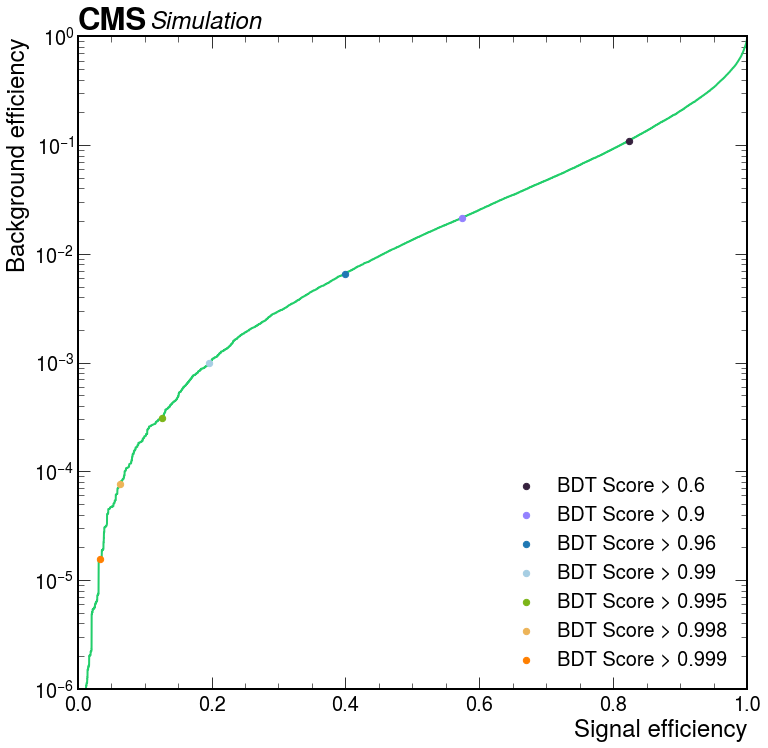

In [35]:
xlim = [0, 1]
ylim = [1e-6, 1]

plot_thresholds = [0.6, 0.9, 0.96, 0.99, 0.995, 0.998, 0.999]
th_colours = [
    "#36213E",
    "#9381FF",
    "#1f78b4",
    "#a6cee3",
    "#7CB518",
    "#EDB458",
    "#ff7f00",
    "#a70000",
]

roc_colours = [
    "#23CE6B",
    "#a70000",
]

plt.rcParams.update({"font.size": 24})

pths = {th: [[], []] for th in plot_thresholds}
plt.figure(figsize=(12, 12))
for i, inf in enumerate(["inferences"]):
    roc = rocs[inf]
    c = roc_colours[i]

    plt.plot(
        roc["tpr"],
        roc["fpr"],
        # label=roc_labels[inf],
        linewidth=2,
        color=c,
    )

    for th in plot_thresholds:
        idx = find_nearest(roc["thresholds"], th)
        pths[th][0].append(roc["tpr"][idx])
        pths[th][1].append(roc["fpr"][idx])

for k, th in enumerate(plot_thresholds):
    plt.scatter(
        *pths[th],
        marker="o",
        s=40,
        label=f"BDT Score > {th}",
        color=th_colours[k],
        zorder=100,
    )

hep.cms.label(data=False, rlabel="")
plt.yscale("log")
plt.xlabel("Signal efficiency")
plt.ylabel("Background efficiency")
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.legend(loc="lower right")
plt.savefig(f"{plot_dir}/roc_bdt.pdf", bbox_inches="tight")